In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

## Shared Utilities

In [45]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def forward_selection(df, validation_df, target_col, n_lags=5):
    # Prepare X and y for both training and validation
    y_train = df[target_col]
    X_train = df.drop('soy', axis=1)
    y_val = validation_df[target_col]
    X_val = validation_df.drop('soy', axis=1)

    # Initialize variables
    selected_features = []
    remaining_features = list(X_train.columns)
    best_score = float('-inf')
    n_features = len(X_train.columns)
    r2_scores = []
    val_mse_scores = []  # New list to track validation MSE

    # Perform forward stepwise selection
    for i in range(n_features):
        best_new_score = float('-inf')
        best_new_feature = None
        best_new_val_mse = float('inf')  # Track best validation MSE
        
        # Try each remaining feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_train_subset = X_train[current_features]
            X_val_subset = X_val[current_features]
            
            model = LinearRegression()
            model.fit(X_train_subset, y_train)
            score = model.score(X_train_subset, y_train)
            
            # Calculate validation MSE
            val_predictions = model.predict(X_val_subset)
            val_mse = mean_squared_error(y_val, val_predictions)
            
            if score > best_new_score:
                best_new_score = score
                best_new_feature = feature
                best_new_val_mse = val_mse
        
        if best_new_score > best_score:
            selected_features.append(best_new_feature)
            remaining_features.remove(best_new_feature)
            best_score = best_new_score
            r2_scores.append(best_score)
            val_mse_scores.append(best_new_val_mse)
            print(f"Step {i+1}: Added {best_new_feature} (R² = {best_score:.4f}, Val MSE = {best_new_val_mse:.4f})")
        else:
            break

    # Plot both R² and MSE progression
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(range(1, len(r2_scores) + 1), r2_scores, marker='o')
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('R² Score')
    ax1.set_title('R² Score vs Number of Features')
    ax1.grid(True)
    
    ax2.plot(range(1, len(val_mse_scores) + 1), val_mse_scores, marker='o', color='red')
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Validation MSE')
    ax2.set_title('Validation MSE vs Number of Features')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    print("\nFinal selected features:")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i}. {feature}")

    final_model = LinearRegression()
    final_model.fit(X_train[selected_features], y_train)

    return final_model, selected_features

from sklearn.model_selection import train_test_split
def create_train_test(df): 
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    return train_df, test_df


In [46]:
df = pd.read_csv('merged_data.csv')
df = df.set_index("DATE")

## Fit the model without any feature engineering

We see that the R2 doen't increase much beyond the original 0.9 mark. Additionally, additional variables only cause the validation MSE to go up, which likely is reflective of the model overfitting.

Step 1: Added maize (R² = 0.8930, Val MSE = 2155.6420)
Step 2: Added wheat (R² = 0.8972, Val MSE = 2220.0273)
Step 3: Added barley (R² = 0.9000, Val MSE = 2320.1067)


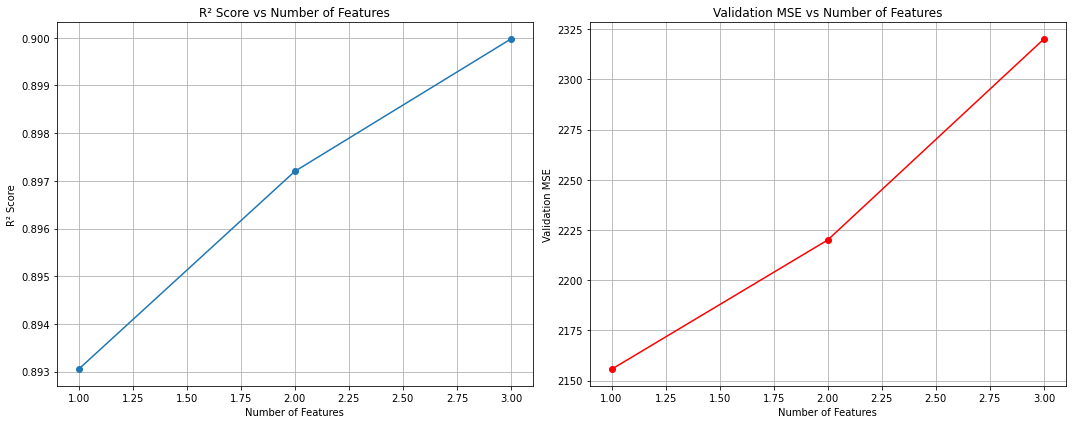


Final selected features:
1. maize
2. wheat
3. barley


In [50]:
train_df, val_df = create_train_test(df)
final_model, selected_features = forward_selection(train_df, val_df, 'soy')

## Now, we will use some feature engineering
With some simple feature engineering, we are able to attain a near 1 R2 for predicting the future values for soy. Our MSE drops from around 2100 to 150 on a hidden validation set, which corresopnds to an error of around 0.5% given the mean value of the soy test dataset is 328. 

In [55]:
def create_features(df, target_col, n_lags=5):
    """Create time series features from the dataset"""
    df_copy = df.copy()
    
    for col in df_copy.columns: 
        # Convert target column to numeric
        df_copy[col] = pd.to_numeric(df_copy[col])
        # df_copy[f'{col}_change'] = df_copy[col].pct_change() 
        for i in range(1, n_lags + 1):
            df_copy[f'{col}_lag_{i}'] = df_copy[col].shift(i)
        
    # Drop rows with NaN values
    df_copy = df_copy.dropna()
    
    return df_copy
df_features = pd.read_csv('merged_data.csv')
df_features = df_features.set_index('DATE')
df_features = create_features(df_features, 'barley')
df_features_train, df_features_test = create_train_test(df_features)

Step 1: Added soy_lag_1 (R² = 0.9733, Val MSE = 395.6326)
Step 2: Added maize (R² = 0.9770, Val MSE = 298.8129)
Step 3: Added maize_lag_1 (R² = 0.9827, Val MSE = 166.2022)
Step 4: Added soy_lag_2 (R² = 0.9841, Val MSE = 154.8788)
Step 5: Added maize_lag_5 (R² = 0.9843, Val MSE = 156.7883)
Step 6: Added maize_lag_4 (R² = 0.9845, Val MSE = 147.0354)
Step 7: Added wheat (R² = 0.9846, Val MSE = 150.2213)
Step 8: Added wheat_lag_1 (R² = 0.9852, Val MSE = 134.3141)
Step 9: Added wheat_lag_2 (R² = 0.9858, Val MSE = 137.7546)
Step 10: Added wheat_lag_5 (R² = 0.9860, Val MSE = 136.5740)
Step 11: Added barley_lag_2 (R² = 0.9861, Val MSE = 141.9298)
Step 12: Added barley (R² = 0.9865, Val MSE = 143.0086)
Step 13: Added barley_lag_1 (R² = 0.9873, Val MSE = 138.4997)
Step 14: Added wheat_lag_4 (R² = 0.9875, Val MSE = 149.6316)
Step 15: Added soy_lag_3 (R² = 0.9875, Val MSE = 152.4867)
Step 16: Added soy_lag_4 (R² = 0.9877, Val MSE = 157.1100)
Step 17: Added wheat_lag_3 (R² = 0.9878, Val MSE = 161.9

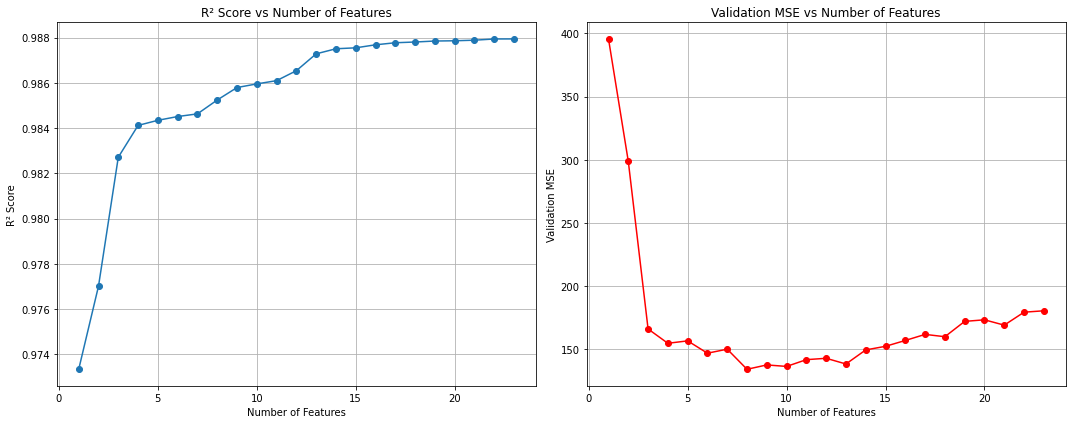


Final selected features:
1. soy_lag_1
2. maize
3. maize_lag_1
4. soy_lag_2
5. maize_lag_5
6. maize_lag_4
7. wheat
8. wheat_lag_1
9. wheat_lag_2
10. wheat_lag_5
11. barley_lag_2
12. barley
13. barley_lag_1
14. wheat_lag_4
15. soy_lag_3
16. soy_lag_4
17. wheat_lag_3
18. soy_lag_5
19. maize_lag_3
20. barley_lag_3
21. barley_lag_4
22. barley_lag_5
23. maize_lag_2


In [56]:
final_model, selected_features = forward_selection(df_features_train, df_features_test, 'soy')

## Comparing our results to regressions only on the current predicted variable's lags. 
As expected, past values of the current crop are helpful in predicting the future price. However, we observe that the full prediction potential goes up only till 0.87R2, which is lower than that obtained when regressing against the other crops. Additionally, as we showed above, we know that the multi-variable regression isn't just overfitting and learns some true additional representations as the mean MSE in this case is around 350-400, which is higher than the MSE of 150 we are able to attain with the multi variable case.

Step 1: Added soy_lag_1 (R² = 0.9733, Val MSE = 395.6326)
Step 2: Added soy_lag_2 (R² = 0.9765, Val MSE = 366.0345)
Step 3: Added soy_lag_4 (R² = 0.9767, Val MSE = 379.7896)
Step 4: Added soy_lag_3 (R² = 0.9772, Val MSE = 413.1480)
Step 5: Added soy_lag_5 (R² = 0.9773, Val MSE = 413.9963)


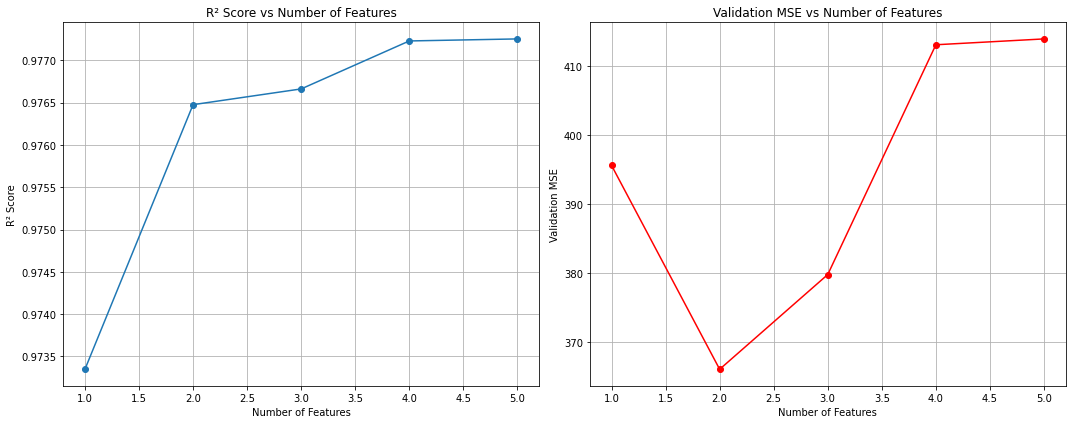


Final selected features:
1. soy_lag_1
2. soy_lag_2
3. soy_lag_4
4. soy_lag_3
5. soy_lag_5


In [57]:
# Only use lags of 'soy' column for prediction
soy_features = [col for col in df_features.columns if col.startswith('soy_lag_')]
final_soy_model, _ = forward_selection(df_features_train[soy_features + ['soy']], 
                                     df_features_test[soy_features + ['soy']], 
                                     'soy')
